# Generate Full Disk images of GOES-R NetCDF files and upload them to GitLab database.

https://gitlab.com/adomakor412/goes-r_fd_image

In [1]:
import sys
from netCDF4 import Dataset
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
#Generates blank plots when saving unless called in same cell
#%matplotlib inline
from mpl_toolkits.basemap import Basemap
from pathlib import Path
from subprocess import Popen
import itertools

from pyproj import Proj
import pyproj
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyresample import image, geometry
import sys
import metpy
import seaborn as sns
sns.set(style="darkgrid")
import pandas as pd
import statsmodels.api as sm
import os
import os.path as op
import glob
from convertdate import gregorian, ordinal
from multiprocessing import Pool

import warnings
#warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger()

/home/radomako/.conda/envs/adomako/lib/python3.9/site-packages/pyresample/bilinear/__init__.py:50: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


## Paths

In [5]:
# storage = Path('../goes-r_fd_image/')
# sharkfins_FD_NC = Path('~/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/')
# caterpillar_FD_NC = Path('~/scratch/gops/amqpfind/adomako_data/l1b_imagery_caterpillar_track/')
storage = '../goes-r_fd_image/'
sharkfins_FD_NC = '~/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/'
caterpillar_FD_NC = '~/scratch/gops/amqpfind/adomako_data/l1b_imagery_caterpillar_track/'

## Functions for unfiltered cloud mask

In [6]:
def Rad2BT(rad, planck_fk1, planck_fk2, planck_bc1, planck_bc2):
    """Radiances to Brightness Temprature (using black body equation)"""
    
    planck_fk1 = abs(planck_fk1)
    planck_fk2 = abs(planck_fk2)
    planck_bc1 = abs(planck_bc1)
    planck_bc2 = abs(planck_bc2)
    
    invRad = np.array(abs(rad))**(-1)
    arg = (invRad*planck_fk1) + 1.0
    T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2)
    return T



def download(url,toPath, saveName):
    cmd = [ 'wget ' + url +' -P ' + toPath +' -O '+ saveName]#if re.search('C07',url)
    #print(cmd)
    pid = Popen(cmd, shell=True)
    pid.communicate()
    return

## Load data

In [7]:
Sat = [16,17]
#band = range(7,17)
year = [2021]
month = list(range(1,3))
day = list(range(1,32))
hour = list(range(1,24))

In [8]:
search = list(itertools.product(Sat,\
        #band,\
        year,\
        month,\
        day,\
        hour))

## Execution

In [13]:
def execute(searchBandTuple):
    chunk, band = searchBandTuple
    filelog = open('log_FD_image.txt','w')

    #for SS, bb, yyyy, mm, dd, hr in chunk:
    #SS, bb, yyyy, mm, dd, hr = chunk
    SS, yyyy, mm, dd, hr = chunk
    bb = band
    SS, bb, yyyy, mm, dd, hr = \
        str(SS).zfill(2),\
        str(bb).zfill(2),\
        str(yyyy).zfill(4),\
        str(mm).zfill(2),\
        str(dd).zfill(2),\
        str(hr).zfill(2)

    calDate = gregorian.date(int(yyyy), int(mm), int(dd))
    DDD = ordinal.from_gregorian(calDate.year, calDate.month, calDate.day)[1]
    DDD = str(DDD).zfill(3)

    #Create Directories    
    cond2 = os.path.exists(f'{storage}/{yyyy}')
    cond3 = os.path.exists(f'{storage}/{yyyy}/{DDD}')
    cond4 = os.path.exists(f'{storage}/{yyyy}/{DDD}/{bb}')

    if not cond2:
        #KEEP CONDITION AS A DYNAMIC F-STRING OTHERWISE VARIABLE IS STATIC, utilize loop
        #make di
            #Create Directoriesrectory per year
        cmd = [f'mkdir {storage}/{yyyy}']
        pid = Popen(cmd, shell=True) 
        pid.communicate()

    if not cond3:
        #KEEP CONDITION AS A DYNAMIC F-STRING OTHERWISE VARIABLE IS STATIC, utilize loop
        #make directory per year
        cmd = [f'mkdir {storage}/{yyyy}/{DDD}']
        pid = Popen(cmd, shell=True) 
        pid.communicate()
        
    if not cond4:
        #KEEP CONDITION AS A DYNAMIC F-STRING OTHERWISE VARIABLE IS STATIC, utilize loop
        #make directory per year
        cmd = [f'mkdir {storage}/{yyyy}/{DDD}/{bb}']
        pid = Popen(cmd, shell=True) 
        pid.communicate()

    try:
        #Not a cd command, use absolute path
        #netcdf = glob.glob(f'~/arcdata/goes/grb/goes{SS}/{yyyy}/{yyyy}_{mm}_{dd}_{DDD}/abi/L1b/RadF/')
        netcdf = glob.glob(f'/arcdata/goes/grb/goes{SS}/{yyyy}/{yyyy}_{mm}_{dd}_{DDD}/abi/L1b/RadF/*')
#         print(yyyy,mm,dd,DDD)
#         print(netcdf)
#         print(len(netcdf))
#         break
        print(netcdf, file=filelog)

        for file in netcdf:
            print(file)
            i = file.find('_s')#+2
            HH = file[i+9: i+11]
            MM = file[i+11: i+13]
            ss = file[i+13: i+15]

            '''
            stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels
            '''
            my_dpi = 192
            resolution = 5424

            GOES_R = xr.open_dataset(file)
            GOES_image = GOES_R['Rad']


            planck_fk1 = float(GOES_R['planck_fk1'].data)
            planck_fk2 = float(GOES_R['planck_fk2'].data) 
            planck_bc1 = float(GOES_R['planck_bc1'].data)                       
            planck_bc2 = float(GOES_R['planck_bc2'].data)
            #Need not convert projection: using full image, no pyproj interpolation of region of interest
            Kelvin_GOES_image = Rad2BT(GOES_image, planck_fk1, planck_fk2, planck_bc1, planck_bc2)

            #Call pixelage before rendering
            plt.figure(figsize=(resolution/my_dpi, resolution/my_dpi), dpi=my_dpi)
            
            fig1 = plt.imshow(Kelvin_GOES_image, vmin=180, vmax=300, cmap='plasma')
            #fig1 = plt.imshow(Kelvin_GOES_image, interpolation='none', vmin=180, vmax=300, cmap='plasma')
            plt.grid(None)
            plt.axis('off')
            #fig1=plt.imshow(Kelvin_GOES_image,cmap='Greys',interpolation='none',vmin=180,vmax=300)

            #print('ERROR IS NOT HERE')
            
            naming = f'{yyyy}/{DDD}/{bb}/FD_goes{SS}_B{bb}_{yyyy}-{mm}-{dd}_{DDD}_{HH}{MM}{ss}'\
                + 'UTC_5424x5424_plain.png'
            
            if not os.path.isfile(op.join(storage,naming)):
                fig1.figure.savefig( op.join(storage,naming) )
            
            #print('ERROR IS NOT HERE')
            
            #fig1 = plt.imshow(GOES_image)
            #plt.clim(180,300)#Kelvin
            #cbar = plt.colorbar(fraction=0.1)
            cbar = plt.colorbar()
            cbar.ax.set_ylabel('Kelvin')
            #plt.grid(None) #Call after the imshow, redraws
            #plt.axis('off')#Call after the imshow, redraws; "layer" to previous drawing

            title = f'Brightness Temperature in Kelvin \n Full Disk GOES-{SS} Image Band{bb}'
            ttl = plt.title(f"{title}\n Date {mm}-{dd}, Year {yyyy}, \n Day {DDD}, Time {HH}:{MM}:{ss}",\
                       fontsize="x-large", fontweight='bold', pad = 6.0)
            ttl.set_position([.5, 1.05])

            naming = f'{yyyy}/{DDD}/{bb}/' + \
                f'FD_goes{SS}_B{bb}_{yyyy}-{mm}-{dd}_{DDD}_{HH}{MM}{ss}UTC_5424x5424.png'
                
            if not os.path.isfile(op.join(storage,naming)):
                fig1.figure.savefig(op.join(storage,naming))

            plt.close('all')
            GOES_R.close()

    except ValueError as e:
        print('THERE IS AN ERROR')
        print('\n', file = filelog)
        print(file, file = filelog)
        print(e, file = filelog)
        print('\n', file = filelog)

    filelog.close()
    return

In [ ]:
agents = 1
chunksize = 3

# use number of bands as agents
with Pool(processes = agents) as pool:
    #pool.map(execute, search, chunksize=None)
    args = [(hour, band) for hour in search for band in range(7,17)]
    pool.map(execute, args, chunksize = chunksize)

/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C10_G16_s20210012000208_e20210012009528_c20210012009570.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C03_G16_s20210011440211_e20210011449519_c20210011449579.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C13_G16_s20210010640211_e20210010649530_c20210010649592.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C06_G16_s20210010950211_e20210010959525_c20210010959563.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C03_G16_s20210012130208_e20210012139516_c20210012139578.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C07_G16_s20210012140208_e20210012149528_c20210012149580.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C15_G16_s20210011920209_e20210011929522_c20210011929589.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/Ra

/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C02_G16_s20210011450211_e20210011459519_c20210011459563.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C15_G16_s20210011500211_e20210011509525_c20210011510008.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C02_G16_s20210012120208_e20210012129516_c20210012129562.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C09_G16_s20210012320208_e20210012329522_c20210012329593.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C10_G16_s20210010210209_e20210010219528_c20210010219579.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C05_G16_s20210012330208_e20210012339516_c20210012339571.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C06_G16_s20210012210208_e20210012219522_c20210012219556.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/Ra

/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C15_G16_s20210010100209_e20210010109522_c20210010109578.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C03_G16_s20210010650211_e20210010659519_c20210010659574.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C02_G16_s20210011140211_e20210011149519_c20210011149560.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C01_G16_s20210010030209_e20210010039517_c20210010039567.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C14_G16_s20210012220208_e20210012229516_c20210012229595.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C03_G16_s20210011020211_e20210011029519_c20210011029578.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C13_G16_s20210011830209_e20210011839528_c20210011840000.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/Ra

/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C14_G16_s20210012250208_e20210012259516_c20210012259598.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C15_G16_s20210011510211_e20210011519525_c20210011520010.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C08_G16_s20210010610211_e20210010619519_c20210010619589.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C10_G16_s20210010940211_e20210010949530_c20210010949580.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C15_G16_s20210010550211_e20210010559525_c20210010559593.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C05_G16_s20210011810209_e20210011819517_c20210011819574.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C03_G16_s20210012350208_e20210012359516_c20210012359573.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/Ra

/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C02_G16_s20210011740209_e20210011749517_c20210011749565.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C05_G16_s20210011450211_e20210011459519_c20210011459580.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C14_G16_s20210010210209_e20210010219517_c20210010220000.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C16_G16_s20210012010208_e20210012019528_c20210012019589.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C01_G16_s20210010620211_e20210010629519_c20210010629578.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C09_G16_s20210011300211_e20210011309525_c20210011309590.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C11_G16_s20210010240209_e20210010249517_c20210010249571.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/Ra

/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C08_G16_s20210012240208_e20210012249516_c20210012249580.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C13_G16_s20210012210208_e20210012219528_c20210012219594.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C03_G16_s20210011430211_e20210011439519_c20210011439581.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C14_G16_s20210012310208_e20210012319516_c20210012319578.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C06_G16_s20210011950208_e20210011959522_c20210011959557.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C06_G16_s20210012320208_e20210012329522_c20210012329563.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C16_G16_s20210011010211_e20210011019530_c20210011019584.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/Ra

/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C07_G16_s20210011220211_e20210011229531_c20210011229580.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C11_G16_s20210011220211_e20210011229519_c20210011229581.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C16_G16_s20210011530211_e20210011539531_c20210011539598.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C10_G16_s20210012050208_e20210012059528_c20210012059572.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C07_G16_s20210010950211_e20210010959531_c20210010959582.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C05_G16_s20210010720211_e20210010729519_c20210010729577.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C01_G16_s20210010350209_e20210010359516_c20210010359568.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/Ra

/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C14_G16_s20210011300211_e20210011309519_c20210011309596.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C04_G16_s20210011600211_e20210011609519_c20210011609550.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C08_G16_s20210010700211_e20210010709519_c20210010709588.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C06_G16_s20210010540211_e20210010549524_c20210010549572.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C07_G16_s20210010150209_e20210010159528_c20210010159581.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C07_G16_s20210010100209_e20210010109528_c20210010109577.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C13_G16_s20210011150211_e20210011159530_c20210011159585.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/Ra

/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C05_G16_s20210012000208_e20210012009516_c20210012009576.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C10_G16_s20210010440209_e20210010449528_c20210010449571.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C11_G16_s20210011610211_e20210011619519_c20210011619580.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C07_G16_s20210011040211_e20210011049530_c20210011049583.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C07_G16_s20210011850209_e20210011859528_c20210011859585.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C08_G16_s20210011150211_e20210011159519_c20210011159588.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C09_G16_s20210010330209_e20210010339522_c20210010339584.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/Ra

/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C05_G16_s20210010120209_e20210010129517_c20210010129572.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C04_G16_s20210012320208_e20210012329516_c20210012329546.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C12_G16_s20210010330209_e20210010339522_c20210010339573.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C07_G16_s20210011110211_e20210011119531_c20210011119584.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C02_G16_s20210010350209_e20210010359517_c20210010359558.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C16_G16_s20210010320209_e20210010329528_c20210010329580.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C04_G16_s20210010300209_e20210010309516_c20210010309544.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/Ra

/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C05_G16_s20210011520211_e20210011529519_c20210011529572.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C08_G16_s20210010930211_e20210010939519_c20210010939586.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C06_G16_s20210012250208_e20210012259522_c20210012259564.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C15_G16_s20210010630211_e20210010639525_c20210010640005.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C07_G16_s20210011610211_e20210011619531_c20210011619585.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C07_G16_s20210012300208_e20210012309528_c20210012309581.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C09_G16_s20210012340208_e20210012349522_c20210012349574.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/Ra

/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C03_G16_s20210011300211_e20210011309519_c20210011309576.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C15_G16_s20210010950211_e20210010959525_c20210010959594.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C07_G16_s20210011730209_e20210011739528_c20210011739585.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C06_G16_s20210011930209_e20210011939522_c20210011939564.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C05_G16_s20210011330211_e20210011339519_c20210011339574.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C14_G16_s20210012200208_e20210012209516_c20210012209589.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C05_G16_s20210010700211_e20210010709519_c20210010709568.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/Ra

/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C12_G16_s20210010750211_e20210010759524_c20210010759584.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C14_G16_s20210010150209_e20210010159516_c20210010159593.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C03_G16_s20210011810209_e20210011819517_c20210011819577.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C01_G16_s20210012330208_e20210012339516_c20210012339565.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C02_G16_s20210010510211_e20210010519519_c20210010519552.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C05_G16_s20210011820209_e20210011829517_c20210011829575.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C09_G16_s20210011410211_e20210011419525_c20210011419599.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/Ra

# Testing

In [2]:
file = 'OR_ABI-L1b-RadF-M6C07_G16_s20210010950211_e20210010959531_c20210010959582.nc'
netcdf = glob.glob(f'/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/{file}')
netcdf = netcdf[0]

myFile = xr.open_dataset(netcdf,engine="netcdf4")
dat = myFile.metpy.parse_cf('Rad')

In [5]:
planck_fk1 = float(myFile['planck_fk1'].data)
planck_fk2 = float(myFile['planck_fk2'].data) 
planck_bc1 = float(myFile['planck_bc1'].data)                       
planck_bc2 = float(myFile['planck_bc2'].data)
print(planck_fk1,planck_fk2,planck_bc1,planck_bc2)

202263.0 3698.18994140625 0.4336099922657013 0.9993900060653687


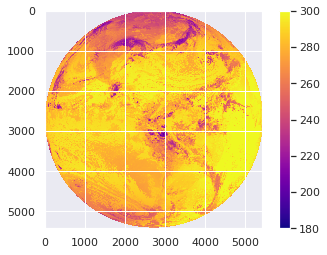

In [13]:
invRad = np.array(abs(dat))**(-1)
arg = (invRad*planck_fk1) + 1.0
T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2)
df = pd.DataFrame(T)

plt.imshow(T, cmap = 'plasma', vmin=180, vmax=300, interpolation='none')
plt.colorbar(fraction=0.1)